# Práctica Final - Computación Bioinspirada
## Transfer Learning aplicado a Red Neuronal Convolucional (ResNet50 && Cifar10).


> Alumno: Juan Antonio Silva Luján



---






![ImagenPortada](https://iartificial.net/wp-content/uploads/2019/02/IA.jpg)

ÍNDICE DE CONTENIDOS:


1.   Introducción a Convolutional Neural Networks
2.   Aplicación con Transfer Learning
3.   Dataset Utilizado
4.   Adaptación a los datos y Arquitectura del modelo
5.   Implementación
6.   Conclusiones





---



## 1. Introducción a Convolutional Neural Networks

Las redes neuronales convolucionales son similares a las redes neuronales multicanal, su principal ventaja es que cada parte de la red se le entrena para realizar una tarea, esto reduce significativamente el número de capas ocultas, por lo que el entrenamiento es más rápido. Además, presenta invarianza a la traslación de los patrones a identificar.

Las redes neuronales convolucionales son muy potentes para todo lo que tiene que ver con el análisis de imágenes, debido a que son capaces de detectar características simples como por ejemplo detención de bordes, lineas, etc y componer en características más complejas hasta detectar lo que se busca.

![Arquitectura](http://www.diegocalvo.es/wp-content/uploads/2017/07/red-neuronal-convolucional-arquitectura.png)

## 2. Aplicación con Transfer Learning
Transfer Learning es un método que nos permite usar Redes que han sido pre-entrenadas en un gran conjunto de datos. Al mantener las primeras capas y solo entrenar las capas recién agregadas, podemos aprovechar el conocimiento adquirido por el algoritmo pre-entrenado y usarlo para nuestra aplicación.
Keras incluye varios modelos de aprendizaje profundo preentrenamiento que se pueden utilizar para la predicción, la extracción de características y el ajuste fino.


## 3. Dataset Utilizado
El propósito de este proyecto final para la asignatura de Computación Bioinspirada es enfocarse en la extracción de características usando la arquitectura ResNet50 como nuestro modelo previamente entrenado. 

Existen numerosas arquitecturas aplicables a la técnica estudiada en las sesiones de clases relacionadas con TRANSFER LEARNING que se pueden elegir, como VGG16, VGG19, MobileNet, etc. Todas tienen sus ventajas y desventajas para ciertas situaciones. Por ejemplo, MobileNet está diseñado para ser rápido y flexible y funciona mejor en dispositivos móviles. Estos modelos están entrenados en el conjunto de datos ImageNet que contenía 1,4 millones de imágenes etiquetadas y 1000 clases diferentes.

Para poner a prueba este proyecto vamos a usar el dataset CIFAR10 ya que contiene una gran cantidad de imágenes con 10 clases diferentes, es decir, 10 posibles resultados. Este dataset puede encontrarse con toda su información en el siguiente enlace:

https://www.cs.toronto.edu/~kriz/cifar.html

Una de las características más cómodas sobre el dataset CIFAR-10 es que no es necesario descargar las imágenes por separado y cargarlas en un directorio, podemos importarlo desde los paquetes de Keras. 

Es necesario realizar un preprocesamiento previo, ya que ResNet50 requiere que las imágenes tengan un mínimo de 200x200 píxeles, mientras que el conjunto de datos CIFAR-10 tiene imágenes de 32x32 píxeles. Esto se puede hacer reformando las imágenes de antemano o ampliando las imágenes antes de introducirlas en las capas convolucionales.

![Imagen dataset CIFAR-10](https://www.bayeswatch.com/assets/cinic/images/cifar-airplane.png)


# 4. Adaptación a los datos y Arquitectura del modelo

Para que el conjunto de datos CIFAR-10 se ejecute con ResNet50, primero debemos muestrear nuestras imágenes 3 veces, para que se ajusten a las capas convolucionales de ResNet50 como se mencionó anteriormente. Hay formas adicionales de hacerlo, como el uso de la función integrada ImageDataGenerator de Keras, pero a los efectos de ejecutar el modelo, el muestreo ascendente también funcionará. El muestreo ascendente es simplemente una forma de ampliar nuestra imagen para agrandarla. 

Después de que las imágenes estén listas para las capas ResNet50, podemos pasar a través de nuestras imágenes y luego tomar la salida, aplanarla y pasarla a una red completamente conectada que forma un conjunto de 2 capas ocultas (una con 128 neuronas y la otra con 64 neuronas) . 

Estas dos capas consisten en una capa de BatchNormalization antes de la capa real y una capa de abandono para la salida. 

Por último, tenemos una capa densa final como salida con 10 neuronas y una salida softmax para las 10 clases que existen en CIFAR10. Softmax esencialmente nos dará la probabilidad de cada clase, en este caso los 10 resultados, que deberían sumar todos iguales a 1

La normalización por lotes se usa para mejorar la velocidad, el rendimiento y la estabilidad de las redes neuronales artificiales.

## 5. Implementación

En primer lugar, es estrictamente necesario cargar todas las librerias que van a ser usadas durante la totalidad de la ejecución del proyecto.

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import tensorflow as tf
from keras.utils import np_utils
from keras.models import load_model
from keras.datasets import cifar10
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

Using TensorFlow backend.


A continuación, carguaremosmos ResNet50 solo con las capas convolucionales y no con las capas densas para que podamos entrenar nuestro nuevo conjunto de datos en las nuevas capas densas que crearemos a continuación.

También vamos a examinar mediante la función summary() la arquitectura ResNet.

In [ ]:
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
94773248/94765736 [==============================] - 2s 0us/step


In [ ]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 100, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Para el nuevo conjunto de datos, trabajemos con el conjunto de datos cifar10 que podemos cargar directamente desde la biblioteca de conjuntos de datos de keras. La descripción de los datos de Cifar10 es la siguiente: "El conjunto de datos CIFAR-10 consta de 60000 imágenes en color de 32x32 en 10 clases, con 6000 imágenes por clase.


1.   50000 imágenes de entrenamiento
2.   10000 imágenes de prueba




In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

print(x_train.shape)
print(x_test.shape)

170500096/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


La imagen de entrada de Cifar10 es de tamaño 32x32, por lo que debe ser escalada 3 veces antes de que podamos pasarla a través de las capas de ResNet. Después de que las imágenes pasan por ResNet, aplanamos nuestra entrada procesada y la pasamos a través de 2 capas densas (con 128 y 64 neuronas respectivamente). 

Cada capa tiene normalización por lotes de antemano y abandono antes de la última capa, con softmax y 10 neuronas. 

Dado que el siguiente método es computacionalmente costoso, solo entrenemos durante 5 épocas, lo que nos da una precisión de entrenamiento del 98%, un resultado bastante eficiente.

In [ ]:
model = models.Sequential()
model.add(layers.UpSampling2D((2,2)))
model.add(layers.UpSampling2D((2,2)))
model.add(layers.UpSampling2D((2,2)))
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train, epochs=5, batch_size=20, validation_data=(x_test, y_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 485s 10ms/sample - loss: 0.2462 - acc: 0.9125 - val_loss: 0.1135 - val_acc: 0.9605
Epoch 2/5
50000/50000 [==============================] - 471s 9ms/sample - loss: 0.1592 - acc: 0.9426 - val_loss: 0.0739 - val_acc: 0.9756
Epoch 3/5
50000/50000 [==============================] - 470s 9ms/sample - loss: 0.1201 - acc: 0.9589 - val_loss: 0.0482 - val_acc: 0.9840
Epoch 4/5
50000/50000 [==============================] - 470s 9ms/sample - loss: 0.0962 - acc: 0.9689 - val_loss: 0.0421 - val_acc: 0.9864
Epoch 5/5
50000/50000 [==============================] - 470s 9ms/sample - loss: 0.0779 - acc: 0.9759 - val_loss: 0.0389 - val_acc: 0.9875


Vamos a guardar el modelo como un archivo h5 y cargarlo de nuevo para que no tengamos que volver a entrenar cada vez que se produzca la ejecución.

In [ ]:
model.save('my_model.h5')
# del model
model = tf.keras.models.load_model('my_model.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Podemos evaluar el modelo como un conjunto de pruebas produciendo así una precisión de un **98.79%.**

In [ ]:
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 24s 2ms/sample - loss: 0.0389 - acc: 0.9875


[0.03885441437661648, 0.98753995]

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d (UpSampling2D) multiple                  0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 multiple                  0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 multiple                  0         
_________________________________________________________________
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
batch_normalization (BatchNo multiple                  524288    
_________________________________________________________________
dense (Dense)                multiple                  1

## Visualización Número  1
A continuación podemos observar:


*   Las visualizaciones de pérdida
*   Precisión de entrenamiento
*   Validación se muestran a continuación





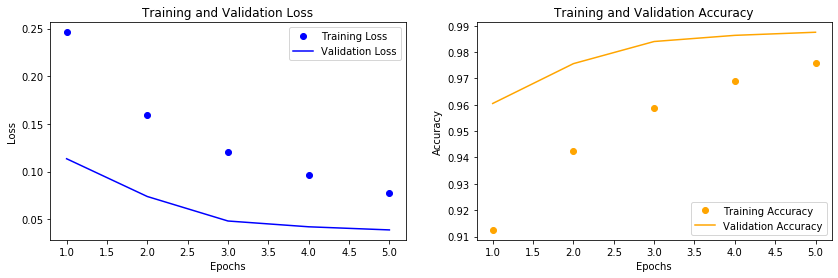

In [ ]:

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss_values, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1, len(loss_values) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training Accuracy', c='orange')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy', c='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

## Visualización Número 2
Ahora podemos ver cómo se ven nuestras imágenes antes de realizar las activaciones respectivas a las capas en ResNet.

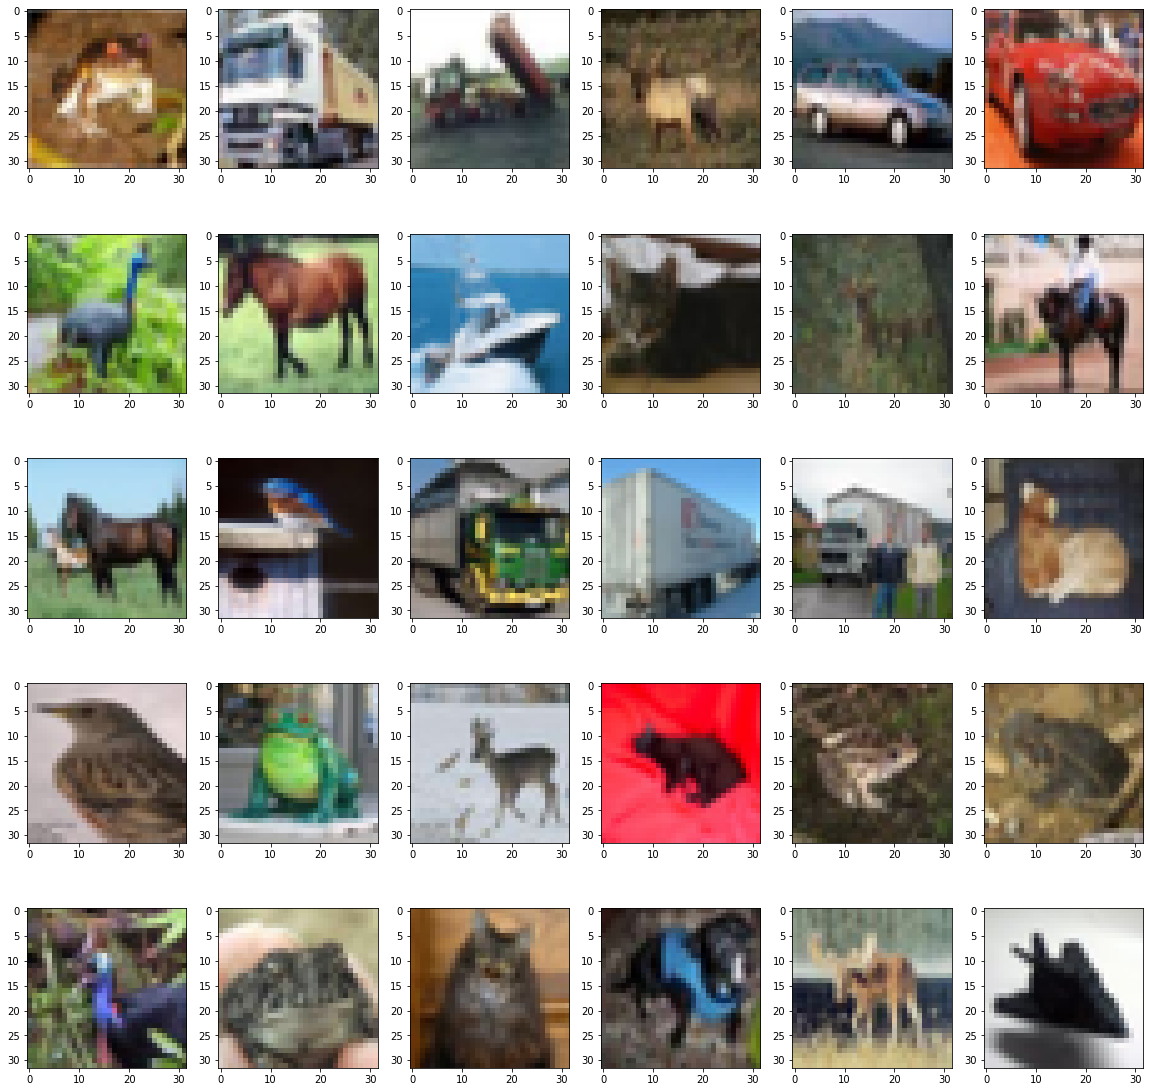

In [ ]:
plt.figure(figsize=(20,20))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.imshow(x_train[i])

In [ ]:
layer_outputs = [layer.output for layer in conv_base.layers[2:8]]

activation_model = models.Model(inputs=conv_base.input, outputs=layer_outputs)

Ahora, se toma una imagen para visualizar los resultados de las activaciones de ResNet.

In [ ]:
img = x_train[30]
# img = Image.fromarray(img, 'RGB')
# img.save('outfile.jpg')
# cv2.imwrite('myImage.png',img)

# img = image.load_img('outfile.jpg', target_size=(200, 200))
# img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img, axis=0)
img_tensor /= 255.

In [ ]:
activations = activation_model.predict(img_tensor)

In [ ]:
first_layer_activation = activations[0]

## Visualización Número 3
La primera imagen muestra las activaciones de la red neuronal cuando se pasa una imagen de un avión.

A continuación se muestra el resultado y posteriormente la imagen original.

In [ ]:
plt.matshow(first_layer_activation[0, :, :, 5], cmap='viridis')
plt.show()

In [ ]:
plt.figure()
plt.imshow(x_train[30])

## 6. Conclusión sobre el proyecto

Transfer Learning nos brinda la capacidad de aprovechar el poder de tener un gran conjunto de datos sin tener que volver a preparar un nuevo modelo desde cero. En este caso ha sido necesario ajustar la red full conected en el modelo pero los resultados que rondan un 98% de media son muy eficientes. 
Para construir el modelo que podemos observar en el summary hay que tener en cuenta quee cada capa se enfoca en diferentes características de cada imagen como por ejemplo los bordes, los ojos... y puede aportar una gran cantidad de información.

